In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob
from scipy.signal import find_peaks
from scipy.signal import peak_widths

# Filter out the light-adapted strips

In [2]:

# output\trial_1\081624_rois_metadata_bignine.csv
metadata_all = pd.read_csv("./output/trial_1/081624_rois_metadata_bignine.csv")

metadata = metadata_all.copy()

# remove the light adapted strips. 
# 1. lower case the filename
metadata['filename'] = metadata['filename'].str.lower()
print(f"Before filtering out light-adapted images there are {len(metadata['filename'])} strips in the metadata.\n")

# 2. remove rows that don't contain 'dark'
metadata = metadata[metadata['filename'].str.contains('dark')]
print(f"After filtering, there are {len(metadata['filename'])} remaining.\n")

# get the strip numbers of the dark adapted strips
strip_filenames = metadata['strip_filename'].unique()

print(f"These are the remaining strips:")
for strip in metadata['strip_filename'].unique():
    print(f"\t{strip}")
    
# get the strips that were filtered out by comparing the strip_filenames in the metadata_all with the strip_numbers
filtered_out = metadata_all[~metadata_all['strip_filename'].isin(strip_filenames)]

print(f"These are the strips that were filtered out:")
for strip in filtered_out['strip_filename'].unique():
    print(f"\t{strip}")
    
    
# create a list of the isolated numbers from the strip filenames
strip_numbers = [int(strip.strip(".png").split('_')[-1]) for strip in strip_filenames]
print(f"\nThese are the strip numbers of the remaining strips: {strip_numbers}")

Before filtering out light-adapted images there are 9 strips in the metadata.

After filtering, there are 8 remaining.

These are the remaining strips:
	strip_106.png
	strip_134.png
	strip_135.png
	strip_161.png
	strip_176.png
	strip_187.png
	strip_229.png
	strip_232.png
These are the strips that were filtered out:
	strip_101.png

These are the strip numbers of the remaining strips: [106, 134, 135, 161, 176, 187, 229, 232]


# Filter the lumen df to only include the dark-adapted strips.

In [3]:
# load the lumen datafile with pd
lumen_data = pd.read_csv("./output/trial_1/csv/lumen_2.csv")

# print the length of the df 
print(f"Before filtering out the light-adapted strips, there are {len(lumen_data)} rows in the lumen data.\n")

# get the lumen data for the strips that were not filtered out
lumen_data = lumen_data[lumen_data['strip'].isin(strip_numbers)]

print(f"After filtering, there are {len(lumen_data)} remaining.\n")

Before filtering out the light-adapted strips, there are 20127 rows in the lumen data.

After filtering, there are 18236 remaining.



# get the threshold metadata so we can reference it

In [4]:
th_metadata = pd.read_csv("./output/trial_1/threshold_metadata_2.csv", index_col=0)
th_metadata["process"] = th_metadata.index
print(th_metadata.head())

                    method  morph_key  equalize  blur  thresh  maxval  \
99_ostuOffset   ostuOffset  closeOpen      True  True      90     255   
100_ostuOffset  ostuOffset  closeOpen      True  True      90     255   
101_ostuOffset  ostuOffset  closeOpen      True  True      90     255   
102_ostuOffset  ostuOffset  closeOpen      True  True      90     255   
103_ostuOffset  ostuOffset  closeOpen      True  True      90     255   

                blocksize  c  \
99_ostuOffset          25  2   
100_ostuOffset         25  2   
101_ostuOffset         25  2   
102_ostuOffset         25  2   
103_ostuOffset         25  2   

                                                       morph_args  offset  \
99_ostuOffset   {'name': 'closeOpen', 'closing_kernel': array(...   1.000   
100_ostuOffset  {'name': 'closeOpen', 'closing_kernel': array(...   1.025   
101_ostuOffset  {'name': 'closeOpen', 'closing_kernel': array(...   1.050   
102_ostuOffset  {'name': 'closeOpen', 'closing_kernel': arra

# calculate the mean width of the lumen, grouped by the process

331
process
100_ostuOffset    5.906844
101_ostuOffset    5.750272
102_ostuOffset    5.563348
103_ostuOffset    5.433558
104_ostuOffset    5.266443
Name: lumen_width_nm, dtype: float64


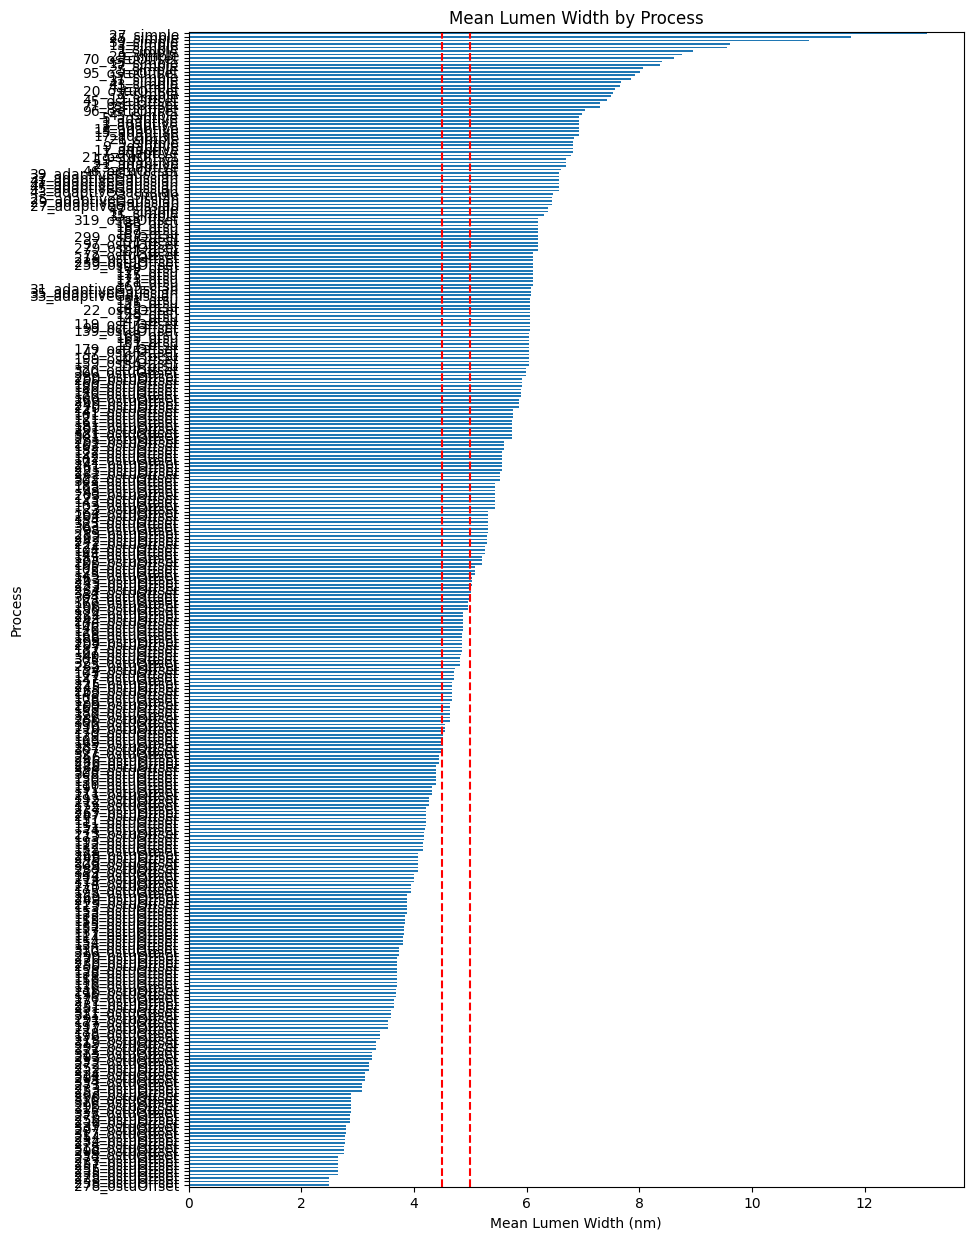

In [5]:

# we need to get the mean width of the lumen for each image, but grouped by process. this is a groupby operation
mean_widths = lumen_data.groupby('process')['lumen_width_nm'].mean()

print(len(mean_widths))
print(mean_widths.head())

# sort the mean widths
mean_widths = mean_widths.sort_values()
expected_range = [4.5, 5]

# plot the mean widths. figsize the first number is the width, the second is the height
plt.figure(figsize=(10, 15))
mean_widths.plot(kind='barh')
plt.xlabel('Mean Lumen Width (nm)')
plt.ylabel('Process')
plt.title('Mean Lumen Width by Process')

# mark a dashed vertical line at the low and high end of the expected range
plt.axvline(expected_range[0], color='r', linestyle='--')
plt.axvline(expected_range[1], color='r', linestyle='--')

plt.show()

# Take a closer look at those in the range

In [6]:
# print the processes in mean_width that are within the range +/- 0.5 nm
# adjusted_range = [expected_range[0] - 0.5, expected_range[1] + 0.5]
adjusted_range = [expected_range[0], expected_range[1]]

adj_mean_widths = mean_widths[mean_widths.between(adjusted_range[0], adjusted_range[1])]
print(adj_mean_widths)
print(type(adj_mean_widths))

process
327_ostuOffset    4.513981
307_ostuOffset    4.513981
287_ostuOffset    4.513981
149_ostuOffset    4.521941
109_ostuOffset    4.521941
129_ostuOffset    4.521941
170_ostuOffset    4.544074
210_ostuOffset    4.544074
190_ostuOffset    4.544074
306_ostuOffset    4.639299
286_ostuOffset    4.639299
326_ostuOffset    4.639299
189_ostuOffset    4.644100
169_ostuOffset    4.644100
209_ostuOffset    4.644100
128_ostuOffset    4.667330
108_ostuOffset    4.667330
148_ostuOffset    4.667330
265_ostuOffset    4.672248
245_ostuOffset    4.672248
225_ostuOffset    4.672248
147_ostuOffset    4.709836
127_ostuOffset    4.709836
107_ostuOffset    4.709836
24_ostuOffset     4.727182
285_ostuOffset    4.823881
325_ostuOffset    4.823881
305_ostuOffset    4.823881
49_ostuOffset     4.843261
167_ostuOffset    4.845331
187_ostuOffset    4.845331
207_ostuOffset    4.845331
208_ostuOffset    4.853193
188_ostuOffset    4.853193
168_ostuOffset    4.853193
126_ostuOffset    4.871001
146_ostuOffset    4.

In [7]:
# get the index for the processes that are within the range
adj_processes = adj_mean_widths.index
print(adj_processes)

Index(['327_ostuOffset', '307_ostuOffset', '287_ostuOffset', '149_ostuOffset',
       '109_ostuOffset', '129_ostuOffset', '170_ostuOffset', '210_ostuOffset',
       '190_ostuOffset', '306_ostuOffset', '286_ostuOffset', '326_ostuOffset',
       '189_ostuOffset', '169_ostuOffset', '209_ostuOffset', '128_ostuOffset',
       '108_ostuOffset', '148_ostuOffset', '265_ostuOffset', '245_ostuOffset',
       '225_ostuOffset', '147_ostuOffset', '127_ostuOffset', '107_ostuOffset',
       '24_ostuOffset', '285_ostuOffset', '325_ostuOffset', '305_ostuOffset',
       '49_ostuOffset', '167_ostuOffset', '187_ostuOffset', '207_ostuOffset',
       '208_ostuOffset', '188_ostuOffset', '168_ostuOffset', '126_ostuOffset',
       '146_ostuOffset', '106_ostuOffset', '244_ostuOffset', '264_ostuOffset',
       '224_ostuOffset', '186_ostuOffset', '206_ostuOffset', '166_ostuOffset'],
      dtype='object', name='process')


In [8]:
# take the index of the th_metadata and create a column
th_metadata['in_range'] = th_metadata.index.isin(adj_processes)
print(len(th_metadata))

# filter the th_metadata to only include the processes that are in the range
df = th_metadata[th_metadata['in_range']].copy()
print(len(df))

240
42


# The best results

In [9]:
# merge the series into the df, joining on the process column
df = df.merge(adj_mean_widths, left_on='process', right_index=True)
df

,method,morph_key,equalize,blur,thresh,maxval,blocksize,c,morph_args,offset,key,process,in_range,lumen_width_nm
106_ostuOffset,ostuOffset,closeOpen,True,True,90,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.175,106_ostuOffset,106_ostuOffset,True,4.871001
107_ostuOffset,ostuOffset,closeOpen,True,True,90,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.200,107_ostuOffset,107_ostuOffset,True,4.709836
108_ostuOffset,ostuOffset,closeOpen,True,True,90,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.225,108_ostuOffset,108_ostuOffset,True,4.667330
109_ostuOffset,ostuOffset,closeOpen,True,True,90,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.250,109_ostuOffset,109_ostuOffset,True,4.521941
126_ostuOffset,ostuOffset,closeOpen,True,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.175,126_ostuOffset,126_ostuOffset,True,4.871001
127_ostuOffset,ostuOffset,closeOpen,True,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.200,127_ostuOffset,127_ostuOffset,True,4.709836
128_ostuOffset,ostuOffset,closeOpen,True,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.225,128_ostuOffset,128_ostuOffset,True,4.667330
129_ostuOffset,ostuOffset,closeOpen,True,True,100,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.250,129_ostuOffset,129_ostuOffset,True,4.521941
146_ostuOffset,ostuOffset,closeOpen,True,True,130,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.175,146_ostuOffset,146_ostuOffset,True,4.871001
147_ostuOffset,ostuOffset,closeOpen,True,True,130,255,25,2,"{'name': 'closeOpen', 'closing_kernel': array(...",1.200,147_ostuOffset,147_ostuOffset,True,4.709836


In [10]:
import os
import shutil
import glob

# Isolate the data that has blurring and equalization, and has an offset within 1.2 and 1.17
df = df[(df['blur'] == True) & (df['equalize'] == True) & (df['offset'].between(1.17, 1.2))]

print(len(df))

# print out the process names in a list:
for process in df['process']:
    print(process)

6
106_ostuOffset
107_ostuOffset
126_ostuOffset
127_ostuOffset
146_ostuOffset
147_ostuOffset


In [11]:
for process in df['process']:
    src = os.path.join("./output/trial_1/processed_images", process)
    dst = os.path.join("./output/trial_1/poi", process)
    os.makedirs(dst, exist_ok=True)
    print(f"Copying {src} to {dst}")
    shutil.copytree(src, dst, dirs_exist_ok=True)
    
    # Copy the masks as well
    masks_src = os.path.join("./output/trial_1/masks", process, "*.png")
    masks_dst = os.path.join(dst, "masks")
    os.makedirs(masks_dst, exist_ok=True)
    for mask in glob.glob(masks_src):
        shutil.copy2(mask, masks_dst)

Copying ./output/trial_1/processed_images\106_ostuOffset to ./output/trial_1/poi\106_ostuOffset
Copying ./output/trial_1/processed_images\107_ostuOffset to ./output/trial_1/poi\107_ostuOffset
Copying ./output/trial_1/processed_images\126_ostuOffset to ./output/trial_1/poi\126_ostuOffset
Copying ./output/trial_1/processed_images\127_ostuOffset to ./output/trial_1/poi\127_ostuOffset
Copying ./output/trial_1/processed_images\146_ostuOffset to ./output/trial_1/poi\146_ostuOffset
Copying ./output/trial_1/processed_images\147_ostuOffset to ./output/trial_1/poi\147_ostuOffset


In [12]:
# for each process, print out the lumen width for each strip
for process in df['process']:
    print(f"Process {process}:")
    
    
    process_df = lumen_data[lumen_data['process'] == process]
    
    for strip in process_df['strip'].unique():
        print(f"Strip {strip}:")
        print(process_df[process_df['strip'] == strip]['lumen_width_nm'])
        
        # print out th mean lumen width for each strip
        print(f"Mean lumen width: {process_df[process_df['strip'] == strip]['lumen_width_nm'].mean()}")
        print("\n")
        

Process 106_ostuOffset:
Strip 106:
344    5.324527
345    5.306677
346    5.287966
347    4.514025
348    4.420345
349    5.116701
350    4.510218
Name: lumen_width_nm, dtype: float64
Mean lumen width: 4.925779795062359


Strip 134:
351    4.419924
352    4.493415
353    4.426456
354    3.667850
Name: lumen_width_nm, dtype: float64
Mean lumen width: 4.251911594058652


Strip 135:
355    5.130271
356    4.691548
357    3.790473
358    3.823082
Name: lumen_width_nm, dtype: float64
Mean lumen width: 4.3588435270330645


Strip 161:
359    4.439086
360    5.109364
361    4.685417
362    4.621059
363    3.558247
364    2.815083
365    4.513217
366    3.766026
Name: lumen_width_nm, dtype: float64
Mean lumen width: 4.1884373313989816


Strip 176:
367    4.155844
368    4.649316
369    3.994361
370    5.057799
371    5.942235
372    5.113636
Name: lumen_width_nm, dtype: float64
Mean lumen width: 4.81886509146511


Strip 187:
373    4.149449
374    6.060606
375    5.143152
376    6.132346
377   